In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os

sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")
pio.templates.default = "plotly_dark"

In [3]:
daily_path, weekly_path, monthly_path  = [], [], []
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
#         print(filename)
        if filename.split('_')[1] == 'daily.csv':
            daily_path.append(os.path.join(dirname, filename))
        elif filename.split('_')[1] == 'weekly.csv':
            weekly_path.append(os.path.join(dirname, filename))
        else:
            monthly_path.append(os.path.join(dirname, filename))
        


In [4]:
# Data frames containing data after a given date. Considering after 2015 (Daily data)
def create_df_list(path=daily_path, date='2015-01-01'):
    df_list = []
    companies = ['GOOG', 'AMZN', 'AAPL', 'META', 'NFLX']
    for i, path in enumerate(daily_path):
        df = pd.read_csv(path)
        df = df[df['Date'] >= date] 
        df['Ticker'] = companies[i]
        df_list.append(df)
    return df_list
df_list = create_df_list()
goog_df, amzn_df, aapl_df, meta_df, nflx_df = df_list


In [5]:
aapl_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 659 to 2950
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2292 non-null   object 
 1   Open       2292 non-null   float64
 2   High       2292 non-null   float64
 3   Low        2292 non-null   float64
 4   Close      2292 non-null   float64
 5   Adj Close  2292 non-null   float64
 6   Volume     2292 non-null   int64  
 7   Ticker     2292 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 161.2+ KB


In [6]:
aapl_df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64

In [7]:
aapl_df.describe() # After 2015 onwards


Open         High          Low        Close    Adj Close  \
count  2292.000000  2292.000000  2292.000000  2292.000000  2292.000000   
mean    192.679751   195.167452   190.308687   192.796047   192.796047   
std      79.230950    80.305493    78.256870    79.291517    79.291517   
min      74.040001    74.830002    72.000000    74.050003    74.050003   
25%     130.649998   132.227497   129.515003   130.944996   130.944996   
50%     177.980003   179.709999   176.129997   177.800003   177.800003   
75%     241.219997   245.265003   238.124996   241.820000   241.820000   
max     472.950012   485.959991   467.470001   474.989990   474.989990   

             Volume  
count  2.292000e+03  
mean   2.375672e+07  
std    1.514370e+07  
min    5.467500e+06  
25%    1.521472e+07  
50%    1.999230e+07  
75%    2.727280e+07  
max    2.323166e+08

In [10]:
## Analysis of Individual Stocks
def create_candlestick(df, name):
    figure = go.Figure(data=[go.Candlestick(x=df["Date"],
                                        open=df["Open"], 
                                        high=df["High"],
                                        low=df["Low"], 
                                        close=df["Close"])])
    figure.update_layout(title = f"{name} Stock Prices since 2015", 
                         xaxis_rangeslider_visible=False)
    figure.show()
    
create_candlestick(aapl_df, "Apple")
create_candlestick(nflx_df, "Netflix")
create_candlestick(meta_df, "Meta")
create_candlestick(goog_df, "Google")
create_candlestick(amzn_df, "Amazon")

In [14]:
## Faceted area charts will tell us the difference/comparison between these stocks
combined_df = pd.concat(df_list, ignore_index=True)
fig = px.area(combined_df, x='Date', y='Close', color='Ticker',facet_col='Ticker',
              labels={'Date':'Year', 'Close':'Closing Price', 'Ticker':'Company'},
              title='Stock Prices for Google, Amazon, Apple, Meta, and Netflix')
fig.show()

In [15]:
## Moving average plots
This will show the pattern inside the data and trend of a stock from the over a period of time


In [18]:
combined_df['MA20'] = combined_df.groupby('Ticker')['Close'].rolling(window=20).mean().reset_index(drop=True)
combined_df['MA40'] = combined_df.groupby('Ticker')['Close'].rolling(window=40).mean().reset_index(drop=True)

for comp, group in combined_df.groupby('Ticker'):
    fig = px.line(group, x='Date', y=['Close', 'MA20', 'MA40'], 
                  title=f"Moving Averages for {comp}")
    fig.show()

In [20]:
## Graph Analysis 
## When the MA20 crosses above the MA40, it is considered a bullish signal indicating that 
## the stock price will continue to rise. Conversely, when the MA20 crosses below the MA40, 
## it is a bearish signal that the stock price will continue falling.

In [23]:
## Volatility
## Volatility is a measure of how much and how often the stock price of a particular company 
## fluctuates over a given period of time and is often used for risk analysis of a stock.

combined_df['Volatility'] = combined_df.groupby('Ticker')['Close'].pct_change().rolling(window=50).std().reset_index(drop=True)

fig = px.area(combined_df, x='Date', y='Volatility', color='Ticker',facet_col='Ticker',
              labels={'Date':'Date', 'Volatility':'Volatility', 'Ticker':'Company'},
              title='Volatility for Google, Amazon, Apple, Meta, and Netflix stocks')
fig.show()

In [24]:
## Graph Analysis

# High volatility indicates that the stock experiences large and frequent price movements, 
# while low volatility indicates that the stock experiences smaller or less frequent price 
# movements. From the above plot it can be seen that Netflix and Meta has the highest volatility
# and the value of the stock price for these companies fluctuates a lot. 
# Investing in these 2 companies can be a little risky compared to the other 3.

In [25]:
## Forecasting of Sales
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [26]:
nflx_df

Date        Open        High         Low       Close   Adj Close  \
3175  2015-01-02   49.151428   50.331429   48.731430   49.848572   49.848572   
3176  2015-01-05   49.258572   49.258572   47.147144   47.311428   47.311428   
3177  2015-01-06   47.347141   47.639999   45.661430   46.501431   46.501431   
3178  2015-01-07   47.347141   47.421429   46.271427   46.742859   46.742859   
3179  2015-01-08   47.119999   47.835712   46.478573   47.779999   47.779999   
...          ...         ...         ...         ...         ...         ...   
5462  2024-02-05  562.469971  575.750000  557.200012  562.059998  562.059998   
5463  2024-02-06  564.119995  566.340027  554.369995  555.880005  555.880005   
5464  2024-02-07  558.159973  567.799988  554.979980  559.299988  559.299988   
5465  2024-02-08  560.549988  563.700012  555.739990  558.530029  558.530029   
5466  2024-02-09  565.000000  566.000000  558.099976  561.320007  561.320007   

        Volume Ticker  
3175  13475000   NFLX  
3176  18165000   NFLX  
3177  16037700   NFLX  
3178   9849700   NFLX  
3179   9601900   NFLX  
...        ...    ...  
5462   4143100   NFLX  
5463   2840300   NFLX  
5464   4373600   NFLX  
5465   3175500   NFLX  
5466   3051600   NFLX  

[2292 rows x 8 columns]

In [27]:
## I will be using the data for the stocks from 2015 onwards excluding the past 3 month data 
## that will be used for testing the model. Also, I will be feeding the data for the 
## last 100 days for the model to predict the stock price on the 100th day. 
## Therefore the vector x_train would be of shape (len(train_data), 100) and y_train would 
## be of shape (len(train_data),)

In [28]:
# Train data excluding roughly last 3 months
train_data = nflx_df.iloc[:-60, 4].values
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data.reshape(-1, 1))

# Create separate lists for features and labels
x_train, y_train = [], []
# Store data for previous 100 days in x_train and the outcomes in y_train
for i in range(100, len(scaled_data)):
    x_train.append(scaled_data[i-100:i, 0])
    y_train.append(scaled_data[i, 0])
    
# Convert x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"Shape of x_train: {x_train.shape}\nShape of y_train: {y_train.shape}")

Shape of x_train: (2132, 100, 1)
Shape of y_train: (2132,)


In [29]:
## Building the model architecture
model = Sequential()
# Add first LSTM layer with dropout
model.add(LSTM(units=64, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
# Add second LSTM layer with dropout
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
# Add third LSTM layer
model.add(LSTM(units=64, return_sequences=False))
# Add dense layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=16)

Epoch 1/50
134/134 [==============================] - 18s 133ms/step - loss: 0.0080
Epoch 2/50
134/134 [==============================] - 19s 140ms/step - loss: 0.0021
Epoch 3/50
134/134 [==============================] - 19s 143ms/step - loss: 0.0018
Epoch 4/50
134/134 [==============================] - 18s 132ms/step - loss: 0.0015
Epoch 5/50
134/134 [==============================] - 18s 132ms/step - loss: 0.0016
Epoch 6/50
134/134 [==============================] - 19s 138ms/step - loss: 0.0012
Epoch 7/50
134/134 [==============================] - 18s 137ms/step - loss: 0.0011
Epoch 8/50
134/134 [==============================] - 18s 131ms/step - loss: 0.0012
Epoch 9/50
134/134 [==============================] - 19s 140ms/step - loss: 0.0011
Epoch 10/50
134/134 [==============================] - 18s 132ms/step - loss: 9.2243e-04
Epoch 11/50
134/134 [==============================] - 18s 134ms/step - loss: 9.2294e-04
Epoch 12/50
134/134 [==============================] - 18s 132ms/s

In [30]:
# Test data contains last 3 months data for the stock + 100 days
test_data = nflx_df.iloc[-60-100:, 4].values
test_data_scaled = scaler.transform(test_data.reshape(-1, 1))

x_test = []
for i in range(100, len(test_data_scaled)):
    x_test.append(test_data_scaled[i-100:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.array(nflx_df.iloc[-60:, 4].values)
print(f"Shape of x_test: {x_test.shape}\nShape of y_test: {y_test.shape}")

Shape of x_test: (60, 100, 1)
Shape of y_test: (60,)


In [31]:
# Get the predicted stock prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

51.12207647295104

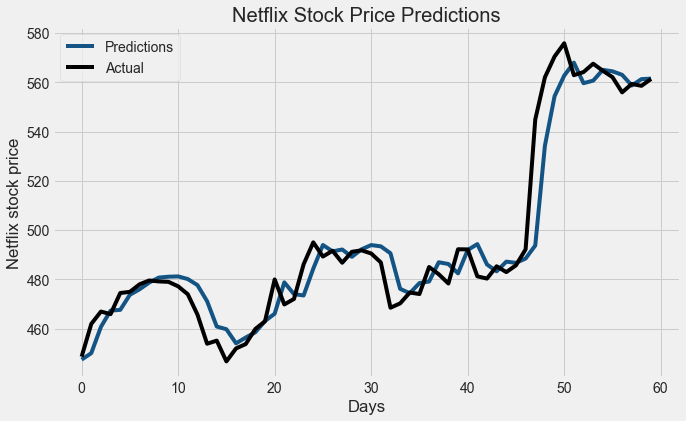

In [32]:
# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(predictions, color = '#135485', label = "Predictions")
plt.plot(y_test, color = 'black', label = "Actual")
plt.xlabel('Days')
plt.ylabel('Netflix stock price')
plt.title("Netflix Stock Price Predictions")
plt.legend()
plt.show()